# Phase 2 → Step 3: Data Cleaning & Preprocessing

Goal: Prepare a high-quality dataset for modeling by fixing structure, types, and noise.

 1. Handle Missing Values
 2. Fix Data Types
 3. Exclude non-feature columns
 4. Feature Engineering
 5. Save Clean Data

In [1]:
import os
os.chdir("..")

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from src.utils.helper import get_config

In [31]:
config = get_config()

df = pd.read_csv(config["data"]["processed"]["combined"])


## Step 1: Handle Missing values

In [4]:

df = df.dropna()

missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0]

Series([], dtype: int64)

## Step 2: Handle Duplicates

In [5]:
df.shape

(4829, 29)

In [6]:
df = df.drop_duplicates()

df.duplicated().sum()

np.int64(0)

In [7]:
df.shape

(4786, 29)

## Step 2: Fix Data Types

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4786 entries, 0 to 4830
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   time_signature            4786 non-null   float64
 1   track_popularity          4786 non-null   int64  
 2   speechiness               4786 non-null   float64
 3   danceability              4786 non-null   float64
 4   playlist_name             4786 non-null   object 
 5   track_artist              4786 non-null   object 
 6   duration_ms               4786 non-null   float64
 7   energy                    4786 non-null   float64
 8   playlist_genre            4786 non-null   object 
 9   playlist_subgenre         4786 non-null   object 
 10  track_href                4786 non-null   object 
 11  track_name                4786 non-null   object 
 12  mode                      4786 non-null   float64
 13  uri                       4786 non-null   object 
 14  type         

In [9]:
# Convert 'track_album_release_date' to datetime

df['track_album_release_date'] = pd.to_datetime(df['track_album_release_date'], errors='coerce')

df['release_year'] = df['track_album_release_date'].dt.year.astype('Int64')
df['release_month'] = df['track_album_release_date'].dt.month.astype('Int64')
df['song_age'] = datetime.now().year - df['release_year'].astype('Int64')

df.head()

,time_signature,track_popularity,speechiness,danceability,playlist_name,track_artist,duration_ms,energy,playlist_genre,playlist_subgenre,...,valence,key,tempo,loudness,acousticness,liveness,track_album_name,release_year,release_month,song_age
0,4.0,23,0.0393,0.636,Rock Classics,Creedence Clearwater Revival,138053.0,0.746,rock,classic,...,0.432,0.0,132.310,-3.785,0.0648,0.1730,The Long Road Home - The Ultimate John Fogerty...,2005,12,20
1,4.0,53,0.0317,0.572,Rock Classics,Van Halen,241600.0,0.835,rock,classic,...,0.795,0.0,129.981,-6.219,0.1710,0.0702,The Collection,2015,3,10
2,4.0,55,0.0454,0.591,Rock Classics,Stevie Nicks,329413.0,0.804,rock,classic,...,0.658,0.0,111.457,-7.299,0.3270,0.0818,Bella Donna (Deluxe Edition),2016,11,9
3,4.0,64,0.1010,0.443,Jazz Classics,"Ella Fitzgerald, Louis Armstrong",185160.0,0.104,jazz,classic,...,0.394,0.0,76.474,-17.042,0.9130,0.1910,"Love, Ella",2007,5,18
4,4.0,62,0.0298,0.685,Jazz Classics,Galt MacDermot,205720.0,0.472,jazz,classic,...,0.475,9.0,80.487,-9.691,0.7850,0.2240,Shapes of Rhythm/Woman Is Sweeter,2000,1,25


In [10]:

missing_values = df.isnull().sum().sort_values(ascending=False)
mising_percent = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

missing_summary = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing %': mising_percent
})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]
missing_summary

,Missing Count,Missing %
track_album_release_date,138,2.88341
release_month,138,2.88341
release_year,138,2.88341
song_age,138,2.88341


## Summary:

* 2.9% of missing values, That’s small.

* Since the date features are **important predictors** (since newer songs can trend differently), then those rows can be safely removed.

Why this is fine:

* Only ~3% of data gone — not much loss.

* Keeps your year, month, and age columns clean and consistent.

* Avoids introducing fake values that could mislead the model.

In [11]:
df = df.dropna(subset=['track_album_release_date', 'release_month', 'release_year', 'song_age'])

missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0]

Series([], dtype: int64)

In [12]:
df.shape

(4648, 32)

**Convert to categorical:**

* Some features like: `mode`, `key`, and `time_signature` are stored as numerical but they actually **don't represent continuous or ordered quantities.**

* We keep `mode` as float becos it is already 0 or 1
* We mark rest as categorical, because their values are labels, not magnitudes.

In [13]:
df['key'] = df['key'].astype('category')
df['time_signature'] = df['time_signature'].astype('category')


Key, time_signature: One-hot encoding is best because each key is distinct, not ranked.

Text(0, 0.5, 'Track Popularity')

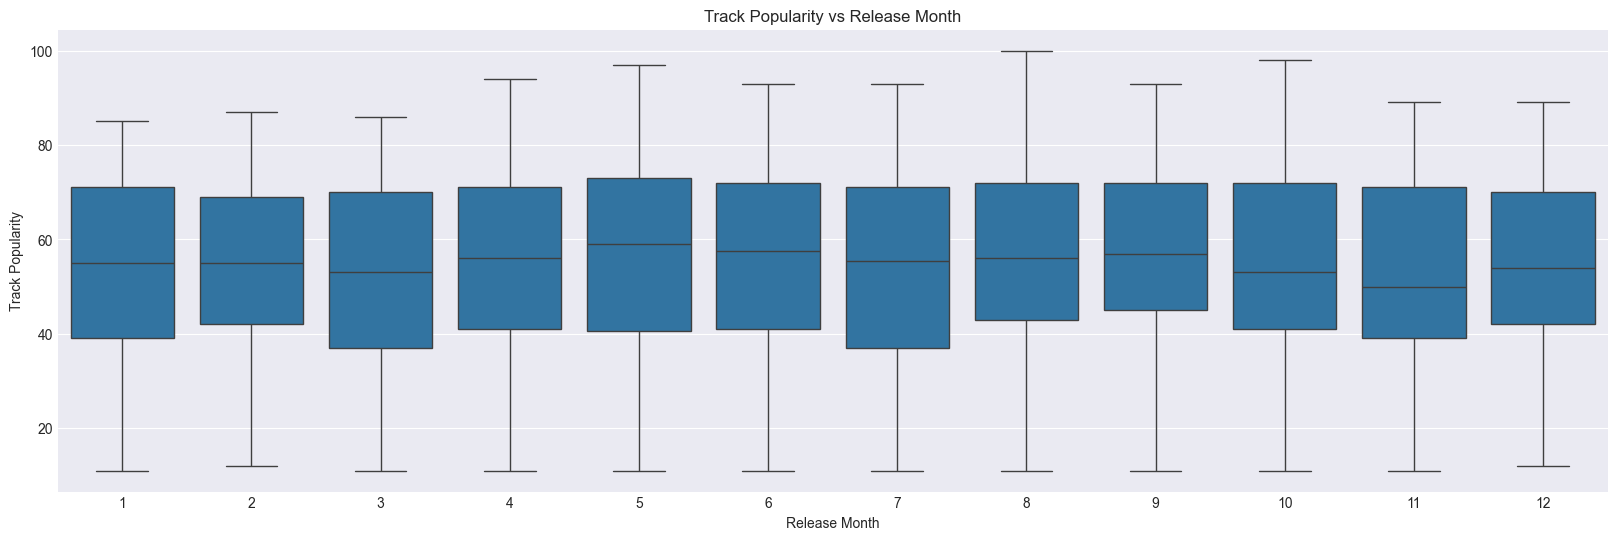

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams["figure.figsize"] = (20, 6)



sns.boxplot(x='release_month', y='track_popularity', data=df)
plt.title('Track Popularity vs Release Month')
plt.xlabel('Release Month')
plt.ylabel('Track Popularity')

C:\Users\ecole\AppData\Local\Temp\ipykernel_13364\3111158567.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


Text(0, 0.5, 'Average Track Popularity')

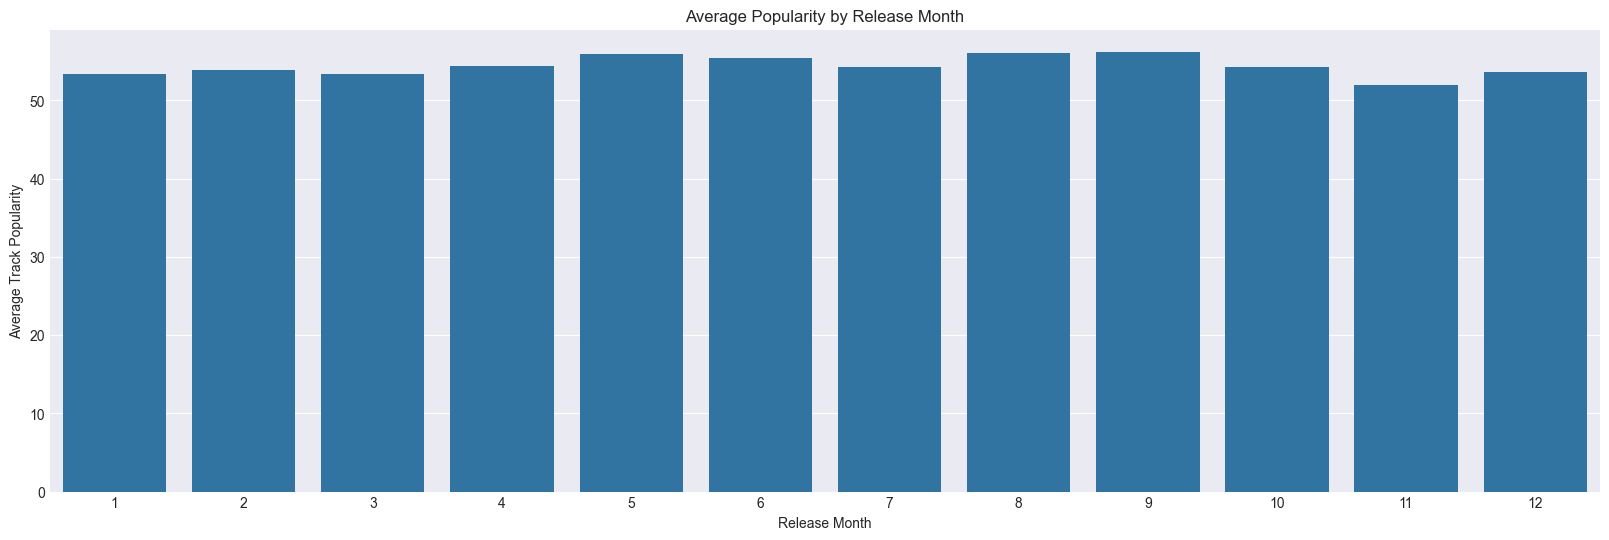

In [16]:
sns.barplot(
    x='release_month',
    y='track_popularity',
    data=df,
    estimator='mean',
    ci=None
)
plt.title('Average Popularity by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Average Track Popularity')

## Summary:

* `release_month` has NO predictive value

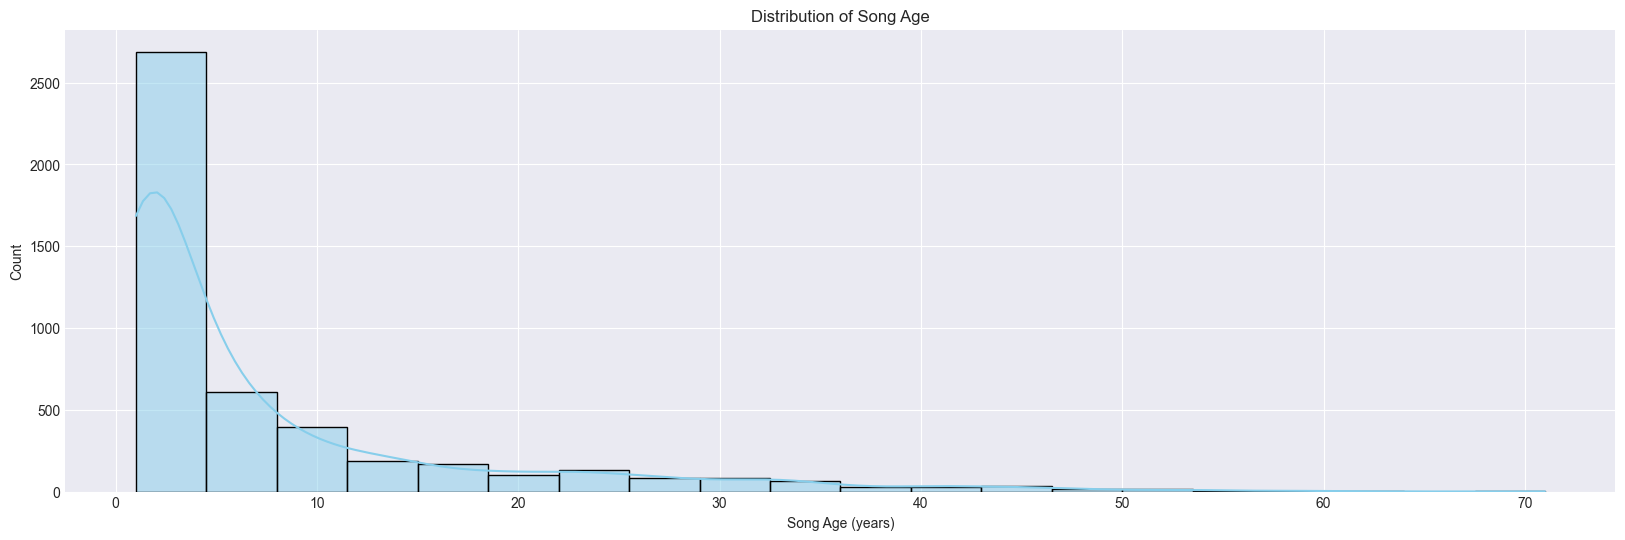

In [17]:

sns.histplot(df['song_age'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Song Age")
plt.xlabel("Song Age (years)")
plt.ylabel("Count")
plt.show()


## Step 4: Feature Engineering

* Step 1. Identify features to scale

→ Why: Models like Linear Regression and KNN are sensitive to feature magnitude.

* Category-like numeric columns: we one-hot encode them so the model doesn’t assume numerical relationships.

* Step 3. Save the clean, engineered dataset

### ✅ Features Scaling Plan:

**Goal**:
Bring all numeric features to a similar range so that no feature dominates others because of its numeric magnitude.

| Feature       | Current Range      | Distribution Shape    | Scaling Type             | Why                                                                              |
| ------------- | ------------------ | --------------------- | ------------------------ | -------------------------------------------------------------------------------- |
| `duration_ms` | 35,000 → 1,355,000 | Strongly right-skewed | **Log + StandardScaler** | Extremely large range — log transform first to reduce skewness, then standardize |
| `tempo`       | 48 → 241           | Roughly normal        | **StandardScaler**       | Standardize to mean 0, std 1                                                     |
| `loudness`    | -48 → 1            | Slightly skewed       | **StandardScaler**       | Works well for normally distributed or near-normal values                        |
| `song_age`    | 1 → 71             | Right-skewed          | **MinMaxScaler (0–1)**   | Easier to interpret and doesn’t distort small values too much                    |


---


> #### Apply Scaling
>
> Plan:
>
> 1. Apply log transform to `duration_ms`
> 2. Standardize `tempo` and `loudness`
> 3. Normalize `song_age` (0–1)
> 4. Create new scaled columns
> 5. Save cleaned data to `data/processed/`


In [18]:

df['duration_ms_log'] = np.log1p(df['duration_ms'])


In [19]:
scaler = StandardScaler()
minmax = MinMaxScaler()

df[['tempo_scaled', 'loudness_scaled', 'duration_ms_log_scaled']] = scaler.fit_transform(df[['tempo', 'loudness', 'duration_ms_log']])
df['song_age_scaled'] = minmax.fit_transform(df[['song_age']])

In [20]:
df[['tempo_scaled', 'loudness_scaled', 'duration_ms_log_scaled', 'song_age_scaled']].describe().T

,count,mean,std,min,25%,50%,75%,max
tempo_scaled,4648.0,5.625640e-16,1.000108,-2.455879,-0.775645,-0.003611,0.648148,4.331952
loudness_scaled,4648.0,-1.712151e-16,1.000108,-5.387175,-0.139944,0.291848,0.553600,1.478002
duration_ms_log_scaled,4648.0,1.455328e-15,1.000108,-5.191345,-0.618519,-0.001096,0.552549,5.942774
song_age_scaled,4648.0,9.480268e-02,0.144207,0.000000,0.000000,0.028571,0.114286,1.000000


#### ✅ Verdict

Scaling was done correctly and the stats confirm it:

* Mean around 0 (or small positive if min–max)

* Std ≈ 1 for standard-scaled features

* Ranges look normal, no extreme distortions

In [21]:
df.columns

Index(['time_signature', 'track_popularity', 'speechiness', 'danceability',
       'playlist_name', 'track_artist', 'duration_ms', 'energy',
       'playlist_genre', 'playlist_subgenre', 'track_href', 'track_name',
       'mode', 'uri', 'type', 'track_album_release_date', 'analysis_url', 'id',
       'instrumentalness', 'track_album_id', 'playlist_id', 'track_id',
       'valence', 'key', 'tempo', 'loudness', 'acousticness', 'liveness',
       'track_album_name', 'release_year', 'release_month', 'song_age',
       'duration_ms_log', 'tempo_scaled', 'loudness_scaled',
       'duration_ms_log_scaled', 'song_age_scaled'],
      dtype='object')

### ✅ Features to Encode:

| Feature          | Best Encoding                                                      |
| ---------------- | ------------------------------------------------------------------ |
| `mode`           | **Keep as is**, because they already only have two categories (0,1)    |
| `key`            | **One-Hot encode**, because no natural order                           |
| `time_signature` | **One-Hot encode**, because no natural order                           |


In [22]:
categorical_cols = ['key', 'time_signature']

# Create and fit the encoder
encoder = OneHotEncoder(drop='first', sparse_output=False) # drop the first column to avoid redundancy
encoded = encoder.fit_transform(df[categorical_cols])

# Convert encoded array back to DataFrame
encoded_cols = encoder.get_feature_names_out(categorical_cols)  # Get proper column names
df_encoded = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)

# Merge with original dataframe
df = pd.concat([df.drop(columns=categorical_cols), df_encoded], axis=1)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4648 entries, 0 to 4830
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   track_popularity          4648 non-null   int64         
 1   speechiness               4648 non-null   float64       
 2   danceability              4648 non-null   float64       
 3   playlist_name             4648 non-null   object        
 4   track_artist              4648 non-null   object        
 5   duration_ms               4648 non-null   float64       
 6   energy                    4648 non-null   float64       
 7   playlist_genre            4648 non-null   object        
 8   playlist_subgenre         4648 non-null   object        
 9   track_href                4648 non-null   object        
 10  track_name                4648 non-null   object        
 11  mode                      4648 non-null   float64       
 12  uri                      

In [24]:
df.head()

,track_popularity,speechiness,danceability,playlist_name,track_artist,duration_ms,energy,playlist_genre,playlist_subgenre,track_href,...,key_5.0,key_6.0,key_7.0,key_8.0,key_9.0,key_10.0,key_11.0,time_signature_3.0,time_signature_4.0,time_signature_5.0
0,23,0.0393,0.636,Rock Classics,Creedence Clearwater Revival,138053.0,0.746,rock,classic,https://api.spotify.com/v1/tracks/5e6x5YRnMJIK...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,53,0.0317,0.572,Rock Classics,Van Halen,241600.0,0.835,rock,classic,https://api.spotify.com/v1/tracks/5FqYA8KfiwsQ...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,55,0.0454,0.591,Rock Classics,Stevie Nicks,329413.0,0.804,rock,classic,https://api.spotify.com/v1/tracks/5LNiqEqpDc8T...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,64,0.1010,0.443,Jazz Classics,"Ella Fitzgerald, Louis Armstrong",185160.0,0.104,jazz,classic,https://api.spotify.com/v1/tracks/78MI7mu1LV1k...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,62,0.0298,0.685,Jazz Classics,Galt MacDermot,205720.0,0.472,jazz,classic,https://api.spotify.com/v1/tracks/6MN6yRVriszu...,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### 🧹 Drop Irrelevant Columns

In [25]:
feature_cols = [
    'danceability', 'energy', 'speechiness', 'acousticness',
    'instrumentalness', 'valence', 'loudness_scaled', 'tempo_scaled',
    'liveness', 'duration_ms_log_scaled', 'mode', 'song_age_scaled',
    'key_1.0', 'key_2.0', 'key_3.0', 'key_4.0', 'key_5.0', 'key_6.0',
    'key_7.0', 'key_8.0', 'key_9.0', 'key_10.0', 'key_11.0',
    'time_signature_3.0', 'time_signature_4.0', 'time_signature_5.0'
]

target_col = 'track_popularity'

df_clean = df[feature_cols + [target_col]].copy()


In [26]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4648 entries, 0 to 4830
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   danceability            4648 non-null   float64
 1   energy                  4648 non-null   float64
 2   speechiness             4648 non-null   float64
 3   acousticness            4648 non-null   float64
 4   instrumentalness        4648 non-null   float64
 5   valence                 4648 non-null   float64
 6   loudness_scaled         4648 non-null   float64
 7   tempo_scaled            4648 non-null   float64
 8   liveness                4648 non-null   float64
 9   duration_ms_log_scaled  4648 non-null   float64
 10  mode                    4648 non-null   float64
 11  song_age_scaled         4648 non-null   float64
 12  key_1.0                 4648 non-null   float64
 13  key_2.0                 4648 non-null   float64
 14  key_3.0                 4648 non-null   float

In [27]:
df_clean.head()

,danceability,energy,speechiness,acousticness,instrumentalness,valence,loudness_scaled,tempo_scaled,liveness,duration_ms_log_scaled,...,key_6.0,key_7.0,key_8.0,key_9.0,key_10.0,key_11.0,time_signature_3.0,time_signature_4.0,time_signature_5.0,track_popularity
0,0.636,0.746,0.0393,0.0648,0.290000,0.432,0.768645,0.498184,0.1730,-1.032946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,23
1,0.572,0.835,0.0317,0.1710,0.000377,0.795,0.430300,0.416355,0.0702,0.676219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,53
2,0.591,0.804,0.0454,0.3270,0.000006,0.658,0.280172,-0.234482,0.0818,1.623053,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,55
3,0.443,0.104,0.1010,0.9130,0.000000,0.394,-1.074181,-1.463602,0.1910,-0.136342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,64
4,0.685,0.472,0.0298,0.7850,0.284000,0.475,-0.052335,-1.322606,0.2240,0.185233,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,62


## Save Clean Data

In [32]:
processed_path = config['data']['processed']['clean']
df_clean.to_csv(processed_path, index=False)

print(f"Cleaned data saved to: {processed_path}")


Cleaned data saved to: data/processed/spotify_clean.csv
